In [113]:
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import util
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
import itertools
import pyramid
import datetime as dt


warnings.filterwarnings("ignore") 
rcParams['figure.figsize'] = 20, 16

%matplotlib inline


print('numpy version: %r' % np.__version__)
print('pyramid version: %r' % pyramid.__version__)

numpy version: '1.14.0'
pyramid version: '0.6.5'


## Data analysis

In this part we're gonna transform our data into montly values and append to each entry a date between 1995 and 1998

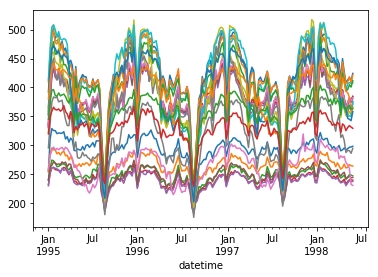

In [193]:
def create_hourly_data(data, hour):
    if(hour < 0 or hour > 23):
        print("Must be between 0 and 24")
        return;
    
    data = list(map(lambda x: (x[0], x[1], int(x[2])), data))
    
    filtered_data = list(filter(lambda x: int(x[2]) == hour, data))
    
    dates = pd.date_range('1995-01-01', periods=len(filtered_data), freq='D')
    
    X = pd.DataFrame(filtered_data)
    
    X.rename(columns={0: 'main_grid',1: 'other_grid', 2: 'hour'}, inplace=True)
    
    X['datetime'] = dates
    X.set_index('datetime', inplace = True)
    
    
    return pd.Series(X['main_grid'] + X['other_grid'])

data, meta = util.read_arf('powersupply.arff');

week_agg = lambda data_: data_.resample('W-Mon').mean()
month_agg = lambda data_: data_.resample('MS').mean()

agg = week_agg

X = [create_hourly_data(data, hour) for hour in range(0, 24)]   

X = [agg(i) for i in X]

[i.plot() for i in X]

plt.show()

### Test Stationary

Using rolling mean and std dev we will plot if our data is stationary or non-stationary.


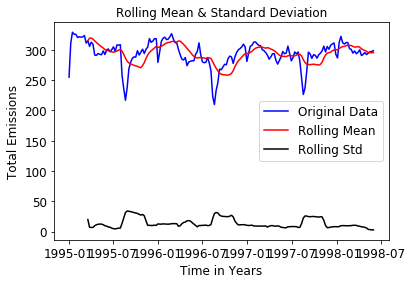

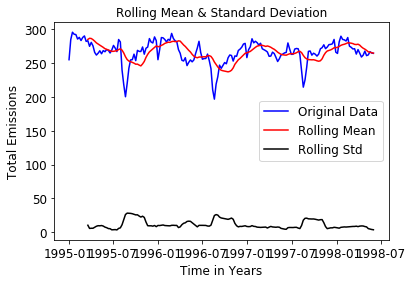

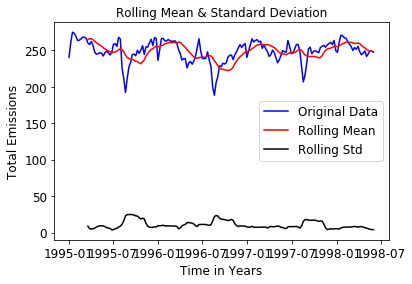

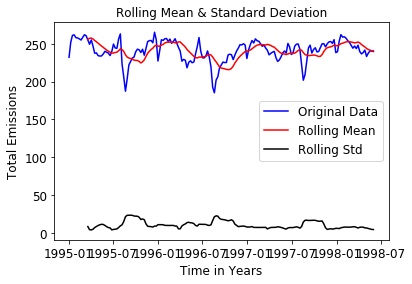

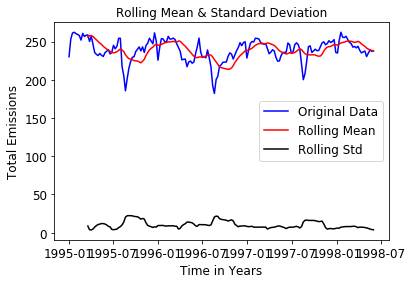

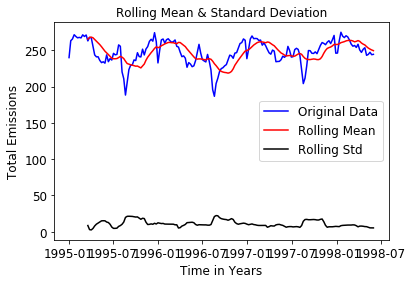

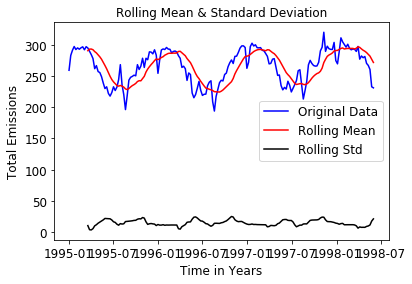

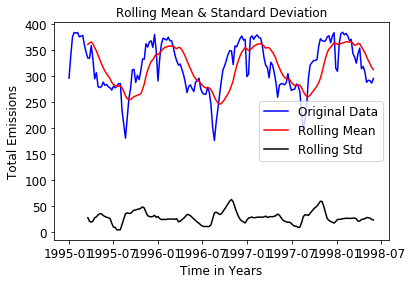

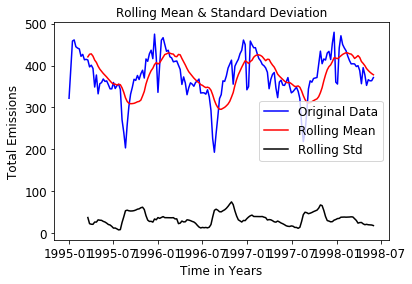

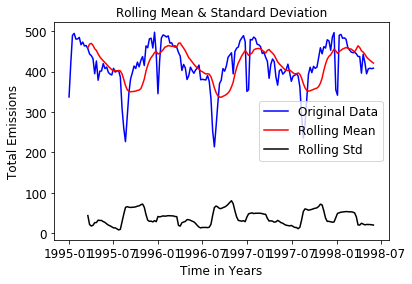

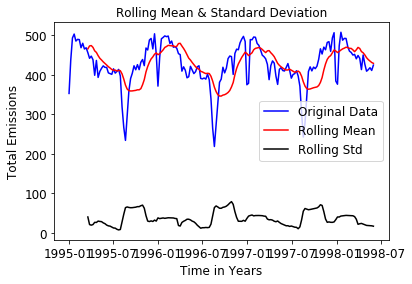

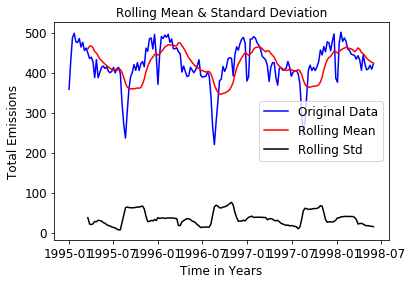

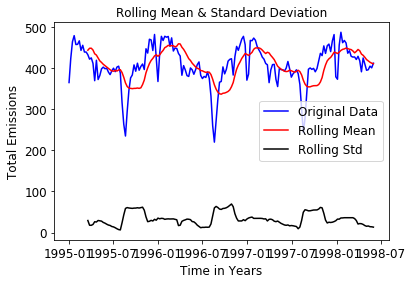

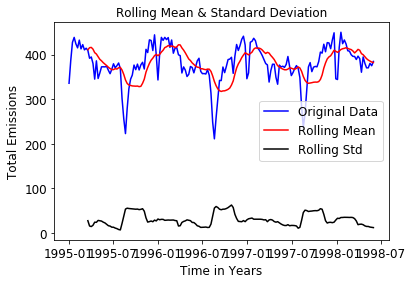

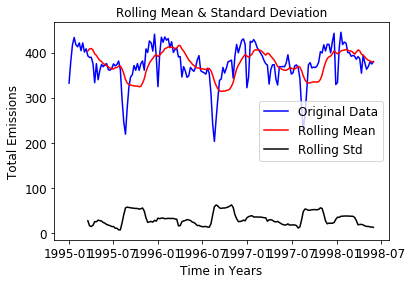

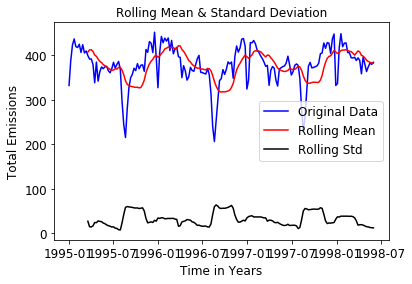

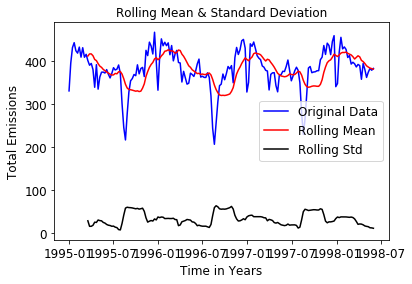

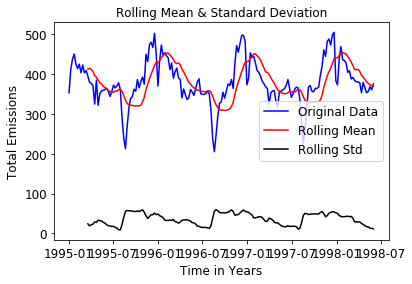

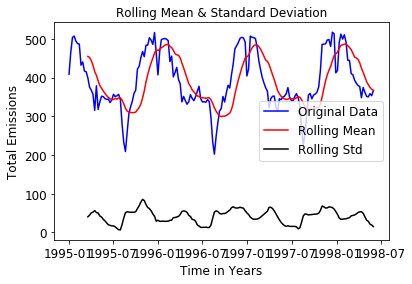

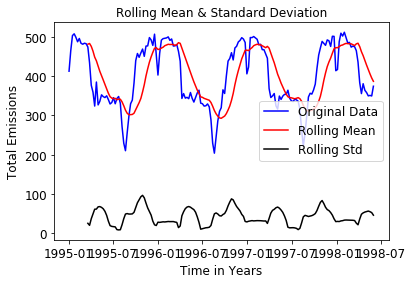

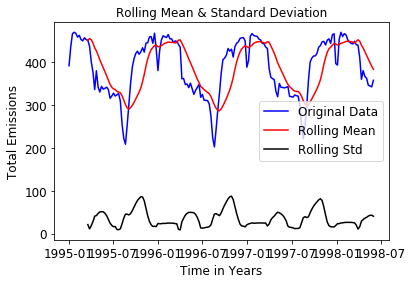

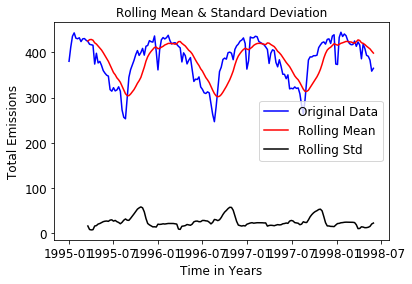

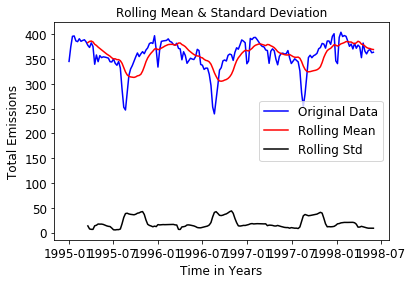

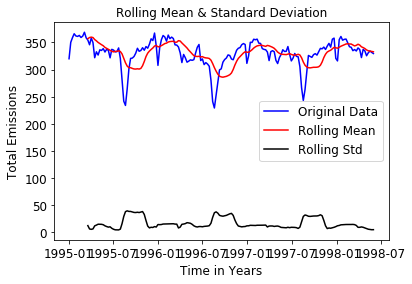

In [194]:
def test_stationary_plot(ts):
    fontsize = 12
    figsize = (12,8)
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    
    plt.xlabel('Time in Years', fontsize = fontsize)
    plt.ylabel('Total Emissions', fontsize = fontsize)
    plt.legend(loc='best', fontsize = fontsize)
    plt.title('Rolling Mean & Standard Deviation', fontsize = fontsize)
    plt.show(block= True)


[test_stationary_plot(i) for i in X]
pass

From the plot we can see that our data does not have increased trend overtime, hence our data should be stationary.

In order to confirm that we will run Dicker Fuller test to confirm this hypothesis.

In [195]:
def test_stationary_adfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
# results in table
[test_stationary_adfuller(i) for i in X]
pass 

Test Statistic                  -5.145322
p-value                          0.000011
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary
Test Statistic                  -5.121399
p-value                          0.000013
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary
Test Statistic                  -5.254624
p-value                          0.000007
#Lags Used                       1.000000
Number of Observat

Test MSE: 108.424


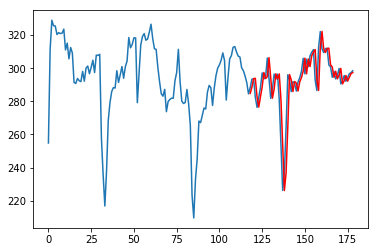

Test MSE: 70.270


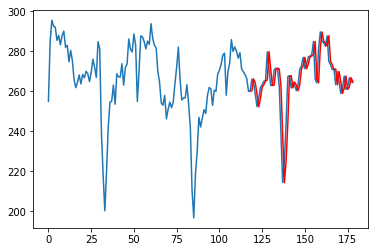

Test MSE: 57.441


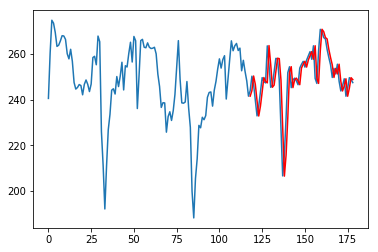

Test MSE: 53.715


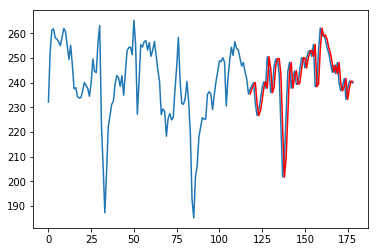

Test MSE: 51.986


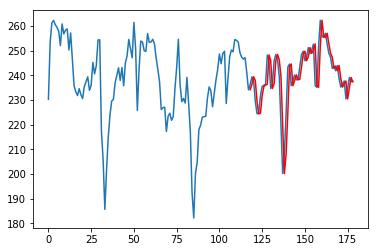

Test MSE: 63.466


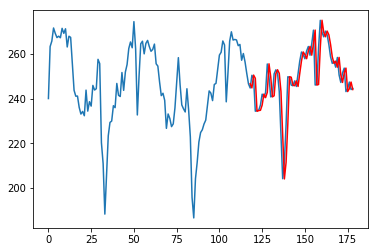

Test MSE: 151.116


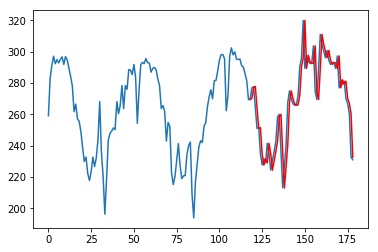

Test MSE: 398.834


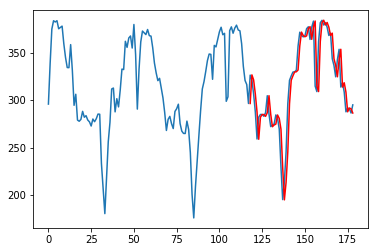

Test MSE: 824.518


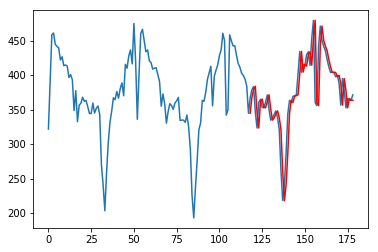

Test MSE: 1255.746


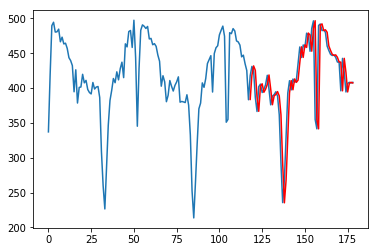

Test MSE: 966.202


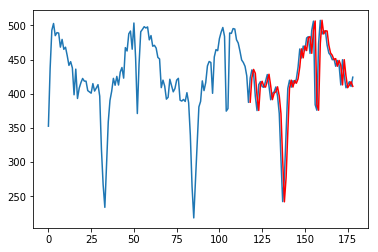

Test MSE: 925.151


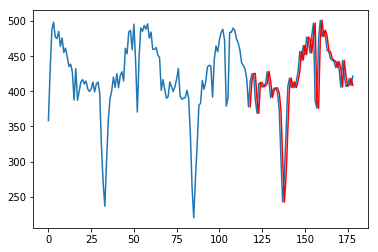

Test MSE: 787.752


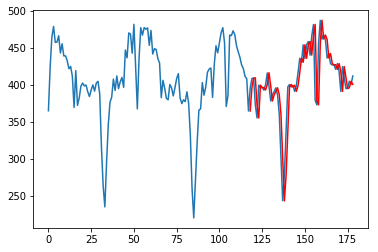

Test MSE: 700.784


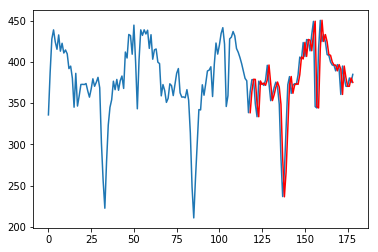

Test MSE: 781.564


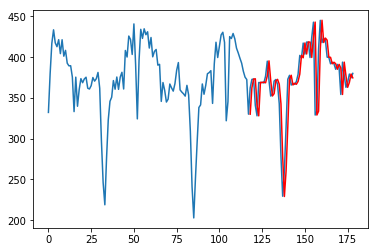

Test MSE: 816.721


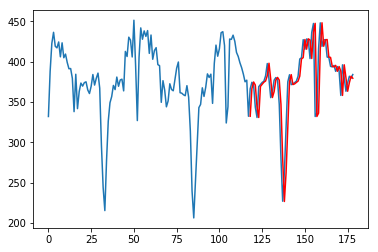

Test MSE: 852.524


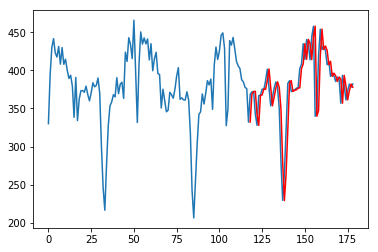

Test MSE: 796.670


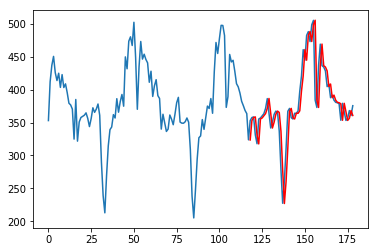

Test MSE: 764.057


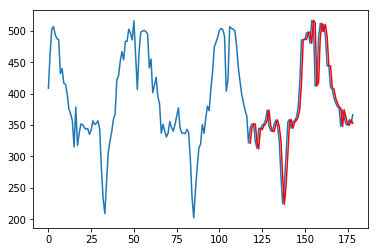

Test MSE: 634.829


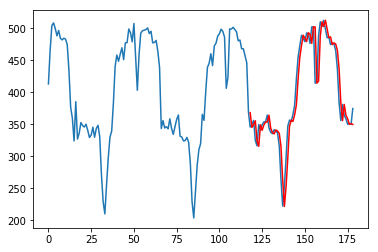

Test MSE: 493.327


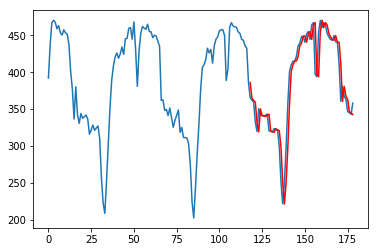

Test MSE: 358.739


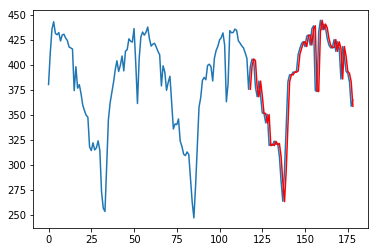

Test MSE: 285.630


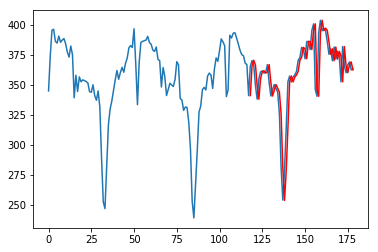

Test MSE: 171.091


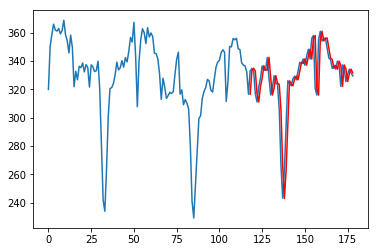

In [196]:
def apply_arima(data, params=(0,1,0)):
    X = data.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    step_prediction = 1
    step_size = 1

    num_steps = len(test)

    i = 0

    while i < num_steps:

        if(num_steps < i+ step_size):
            break;

        model = ARIMA(history, order=params)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast(steps = step_size)

        yhat = [output[0][z] for z in range(step_size)]

        for num in yhat:
            predictions.append(num)

        obs = [test[z] for z in range(i+ step_prediction)]

        for o in obs:
            history.append(o)

        i = i + step_size


    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)

    # plot
    plt.plot(X)
    plt.plot([(i + len(X) - len(predictions)) for i in range(0, len(predictions))], predictions, color='red')
    plt.show()
    

[apply_arima(i) for i in X]
pass

In [126]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1167.643, BIC=1182.924, Fit time=0.416 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1200.597, BIC=1212.822, Fit time=0.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1165.950, BIC=1178.175, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1166.193, BIC=1181.474, Fit time=0.649 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1214.860, BIC=1224.029, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1165.290, BIC=1180.572, Fit time=0.772 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1166.833, BIC=1185.170, Fit time=0.930 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=1174.915, BIC=1187.140, Fit time=0.525 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_orde

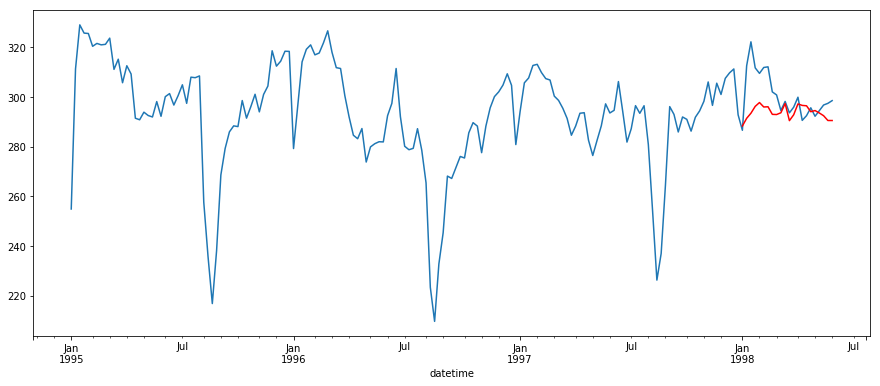

In [121]:
stepwise_fit = auto_arima(y, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

print(stepwise_fit.summary())

next_year_prediction= stepwise_fit.predict(n_periods=periods)

forecasted_year_series = pd.Series(next_year_prediction, index=t.index)

true_values = t.values

predicted_values = next_year_prediction;

# mse = ((predicted_values - true_values) ** 2).mean()

mse = mean_squared_error(true_values, predicted_values)
print('The Mean Squared Error {}'.format(round(mse, 2)))

ax = pd.Series(x).plot(figsize=(15, 6))

forecasted_year_series.plot(color='red', ax=ax)
plt.show()

Test MSE: 108.424


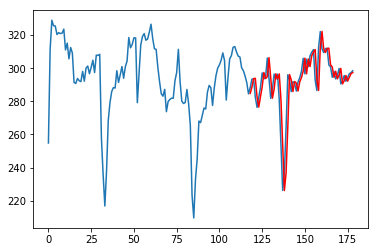

In [142]:
X = pd.Series(x).values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

step_prediction = 1
step_size = 1

num_steps = len(test)
params = (0,1,0)

i = 0

while i < num_steps:
    
    if(num_steps < i+ step_size):
        break;
    
    model = ARIMA(history, order=params)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps = step_size)
    
    yhat = [output[0][z] for z in range(step_size)]
    
    for num in yhat:
        predictions.append(num)
    
    obs = [test[z] for z in range(i+ step_prediction)]
    
    for o in obs:
        history.append(o)
        
    i = i + step_size
    

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(X)
plt.plot([(i + len(X) - len(predictions)) for i in range(0, len(predictions))], predictions, color='red')
plt.show()

# 